In [69]:
# Import necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, f1_score, roc_auc_score, auc, average_precision_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer

# 1. Load the dataset
heart_disease_uci = pd.read_csv('../Data/heart_disease_uci.csv')

# 2. Examine the Dataset: Investigate the dataset before cleaning to find NA values, duplicates, etc.
# heart_disease_uci.head()
heart_disease_uci.info()
# heart_disease_uci.describe()
# heart_disease_uci.tail()
print("Initial shape: ", heart_disease_uci.shape) #dimensions
# heart_disease_uci.columns
# heart_disease_uci.dtypes

# 3. Preprocess the data
print("\nMissing values before pre-processing the dataset:")
print(heart_disease_uci.isnull().sum()) # check missing values in the dataset

## A. drop duplicate rows
heart_disease_uci = heart_disease_uci.drop_duplicates()  # Removes duplicate rows - precautionary step

## B. Remove Redundant Features   
def remove_na_features(data, threshold=0.5):
    """Remove redundant or duplicate columns.
    :param data: pandas DataFrame
    :param threshold: float, threshold percentage
    :return: pandas DataFrame
    """
    null_percent = data.isnull().mean() # to get the % of null values
    # Drop columns with null percent greater than the threshold
    to_drop = null_percent[null_percent > threshold].index
    return data.drop(columns=to_drop)

## Drop columns
heart_disease_uci = remove_na_features(heart_disease_uci, threshold=0.5) # this will remove 'ca' and 'thal'

# Before imputing, isolate numerical and categorical features 
num_cols = heart_disease_uci.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = heart_disease_uci.select_dtypes(include=['object']).columns.tolist()

# For model building, remove target features: 'chol' and 'num'
if "chol" in num_cols:
    num_cols.remove("chol") # for regression models
if "num" in num_cols:
    num_cols.remove("num") # for classification models

print("\nMissing values after dropping redundant columns")
print(heart_disease_uci.isnull().sum()) 

# Prepocessor function: Imputation + Scaling for normality + Encoding to convert categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols), # Fill missing values in numerical columns with median
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols) # One-hot encoding categorical columns into binary
    ]
)


# # 4. Build and Evaluate Models

# Split dataset into features and target: chol
X = heart_disease_uci.drop(columns=['chol', 'num'])  # chol feature
y = heart_disease_uci['chol'].fillna(heart_disease_uci['chol'].median()) # chol target

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now run the split X data through the Preprocessor pipeline
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# OneHotEncoder is preferred over get_dummies for machine-learning purposes when training models
# X_train = pd.get_dummies(X_train, drop_first=True)
# X_test = pd.get_dummies(X_test, drop_first=True)
# # align columns between train and test:
# X_train, X_test = X_train.align(X_test, join ='left', axis=1, fill_value=0)

# Final check to ensure missing values are removed - should ideally output 0
print("\nMissing values after splitting and pre-processing:")
# print(X_train.isnull().sum()) 
# print(X_test.isnull().sum()) 
print(np.isnan(X_train).sum()) # numpy is used here
print(np.isnan(X_test).sum()) 
print(y.isnull().sum()) 

print(X_train.shape)
print(X_test.shape)
# print(X_train.head())
print(X_train[:5])

print("Preprocessing pipeline successfully completed")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB
Initial shape:  (920, 15)

Missing values before pre-processing the dataset:
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol       

c:\Users\rihan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.378e+06, tolerance: 7.226e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\rihan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e+06, tolerance: 6.908e+02 Linear regression models with null weight for the l1 regularization term are more efficiently 

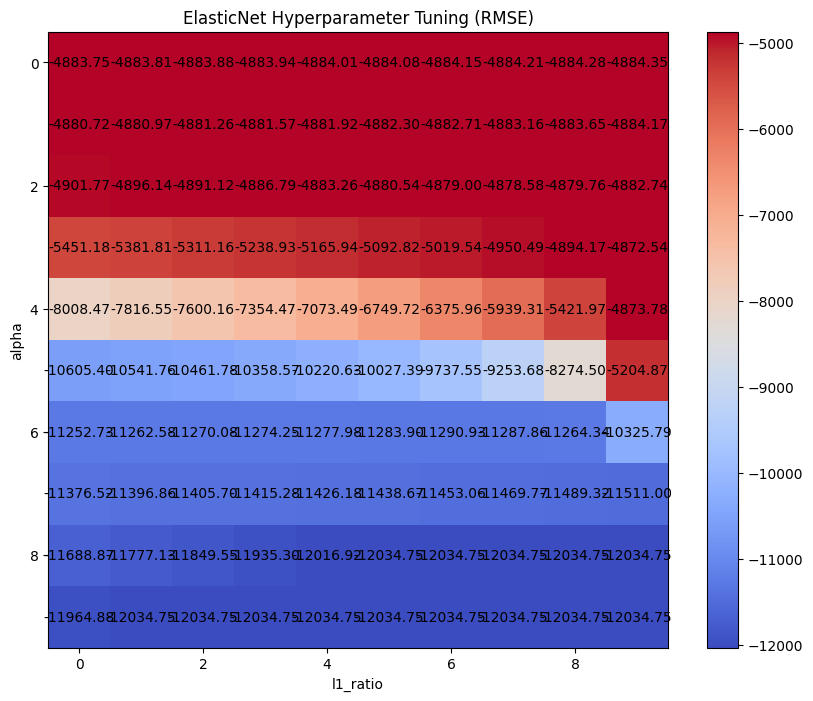

In [ ]:
# 4.1. Regression Models: Linear Regression and ElasticNet
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

# Evaluation metrics for Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# ElasticNet
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)
y_pred_en = elastic_net.predict(X_test)

# Evaluation metrics for ElasticNet
r2_en = r2_score(y_test, y_pred_en)
rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))

# ElasticNet Hyperparameter Tuning (alpha and l1_ratio)
param_grid = {'alpha': np.logspace(-4, 4, 10), 'l1_ratio': np.linspace(0, 1, 10)}
grid_search = GridSearchCV(ElasticNet(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Best ElasticNet hyperparameters and performance
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']
best_rmse = np.sqrt(-grid_search.best_score_)

# Plot Heatmap for R² and RMSE for ElasticNet Hyperparameter Tuning
scores = grid_search.cv_results_['mean_test_score'].reshape(10, 10)
plt.figure(figsize=(10, 8))

# Create an image (mappable) using imshow
heatmap = plt.imshow(scores, cmap='coolwarm', aspect='auto')

# Add annotations
for i in range(scores.shape[0]):
    for j in range(scores.shape[1]):
        plt.text(j, i, f"{scores[i, j]:.2f}", ha='center', va='center', color='black')


# sns.heatmap(scores, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=np.linspace(0, 1, 10), yticklabels=np.logspace(-4, 4, 10))
plt.xlabel('l1_ratio')
plt.ylabel('alpha')
plt.title('ElasticNet Hyperparameter Tuning (RMSE)')
plt.colorbar()
plt.show()

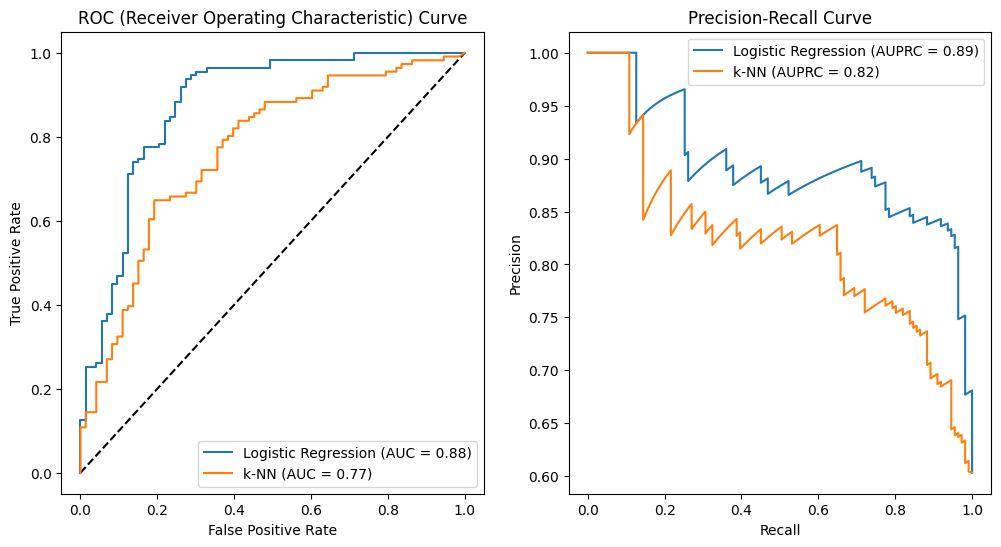

Linear Regression R²: 0.5639, RMSE: 72.5552
ElasticNet R²: 0.2954, RMSE: 92.2247
Best ElasticNet Hyperparameters: alpha = 0.046415888336127774, l1_ratio = 1.0
ElasticNet Best RMSE: 69.8036
Logistic Regression - Accuracy: 0.8152, F1: 0.8455, AUROC: 0.8758, AUPRC: 0.8945
k-NN - Accuracy: 0.6957, F1: 0.7358, AUROC: 0.7663, AUPRC: 0.8215


In [71]:
# 4.2. Classification Models: Logistic Regression and k-NN

# Split dataset into features and target: num (for classification)
X_class = heart_disease_uci.drop(columns=['num'])  # num feature
y_class = (heart_disease_uci['num'] > 0).astype(int)  # num target

# Train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)


X_train_class = preprocessor.fit_transform(X_train_class)
X_test_class = preprocessor.transform(X_test_class)


# Logistic Regression
log_reg = LogisticRegression(penalty='l2', solver='liblinear')  # liblinear chosen for binary classification
log_reg.fit(X_train_class, y_train_class)
y_pred_log_class = log_reg.predict(X_test_class)
y_predproba_log = log_reg.predict_proba(X_test_class)[:, 1]

# Evaluation metrics for Logistic Regression
accuracy_log = accuracy_score(y_test_class, y_pred_log_class) # accuracy scores
f1_log = f1_score(y_test_class, y_pred_log_class) 

# Generate ROC plot
fpr_log, tpr_log, _ = roc_curve(y_test_class, y_predproba_log) 
roc_auc_log = auc(fpr_log, tpr_log)  # Auc values
# Generate Precision-Recall Curve plots
precision_log, recall_log, _ = precision_recall_curve(y_test_class, y_predproba_log)
auprc_log = average_precision_score(y_test_class, y_predproba_log)  # AUPRC


# k-NN Classifier
knn = KNeighborsClassifier(n_neighbors=15, weights='distance', metric='manhattan') # hyperparametric experimentation
knn.fit(X_train_class, y_train_class)
y_pred_knn_class = knn.predict(X_test_class)
y_predbroba_knn = knn.predict_proba(X_test_class)[:, 1]

# Evaluation metrics for k-NN
accuracy_knn = accuracy_score(y_test_class, y_pred_knn_class)
f1_knn = f1_score(y_test_class, y_pred_knn_class) 
# Generate ROC plots
fpr_knn, tpr_knn, _ = roc_curve(y_test_class, y_predbroba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)  # auc values
# Generate Precision-Recall Curve plots
precision_knn, recall_knn, _ = precision_recall_curve(y_test_class, y_predbroba_knn)
auprc_knn = average_precision_score(y_test_class, y_predbroba_knn)  # AUPRC


# Plot AUROC and AUPRC for both Logistic Regression and k-NN
# AUROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--') # diagonal reference
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'k-NN (AUC = {roc_auc_knn:.2f})')
plt.title('ROC (Receiver Operating Characteristic) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# AUPRC
plt.subplot(1, 2, 2)
plt.plot(recall_log, precision_log, label=f'Logistic Regression (AUPRC = {auprc_log:.2f})')
plt.plot(recall_knn, precision_knn, label=f'k-NN (AUPRC = {auprc_knn:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

# Print evaluation metrics
print(f"Linear Regression R²: {r2_lr:.4f}, RMSE: {rmse_lr:.4f}")
print(f"ElasticNet R²: {r2_en:.4f}, RMSE: {rmse_en:.4f}")
print(f"Best ElasticNet Hyperparameters: alpha = {best_alpha}, l1_ratio = {best_l1_ratio}")
print(f"ElasticNet Best RMSE: {best_rmse:.4f}")
print(f"Logistic Regression - Accuracy: {accuracy_log:.4f}, F1: {f1_log:.4f}, AUROC: {roc_auc_log:.4f}, AUPRC: {auprc_log:.4f}")
print(f"k-NN - Accuracy: {accuracy_knn:.4f}, F1: {f1_knn:.4f}, AUROC: {roc_auc_knn:.4f}, AUPRC: {auprc_knn:.4f}")
